# Example Case using Racetrack

Below is an example of how to initialize the Racetrack environment and solve/compare with multiple solvers.

## Boilerplate


If you're playing with things under the hood as you run these, autoreload is always useful...

In [1]:
%load_ext autoreload

%autoreload 2

If necessary, add directory containing lrl to path (workaround for if lrl is not installed as a package)

In [2]:
import sys

# Path to directory containing lrl
sys.path.append('../') 

In [3]:
from lrl import environments, solvers
from lrl.utils import plotting

import matplotlib.pyplot as plt

Logging is used throughout lrl for basic info and debugging. 

In [4]:
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(funcName)s - %(levelname)s - %(message)s',
                    level=logging.INFO, datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

## Initialize an Environment

Initialize the 20x10 racetrack that includes some oily (stochastic) surfaces.

**Note**: Make sure that your velocity limits suit your track.  A track must have a grass padding around the entire course that prevents a car from trying to exit the track entirely, so if max(abs(vel))==3, you need 3 grass tiles around the outside perimeter of your map.  For track, we have a 2-tile perimeter so velocity must be less than +-2.

In [5]:
# This will raise an error due to x_vel max limit
try:
    rt = environments.get_racetrack(track='20x10_U',
                                     x_vel_limits=(-2, 20),  # Note high x_vel upper limit
                                     y_vel_limits=(-2, 2),
                                     x_accel_limits=(-2, 2),
                                     y_accel_limits=(-2, 2),
                                     max_total_accel=2,
                                     )
except IndexError as e:
    print("Caught the following error while building a track that shouldn't work:")
    print(e)
    print("")

# This will work
try:
    rt = environments.get_racetrack(track='20x10_U',
                                 x_vel_limits=(-2, 2),
                                 y_vel_limits=(-2, 2),
                                 x_accel_limits=(-2, 2),
                                 y_accel_limits=(-2, 2),
                                 max_total_accel=2,
                                 )
    print("But second track built perfectly!")
except:
    print("Something went wrong, we shouldn't be here")

Caught the following error while building a track that shouldn't work:
Caught IndexError while building Racetrack.  Likely cause is a max velocity that is creater than the wall padding around the track (leading to a car that can exit the track entirely)

But second track built perfectly!


Take a look at the track using plot_env

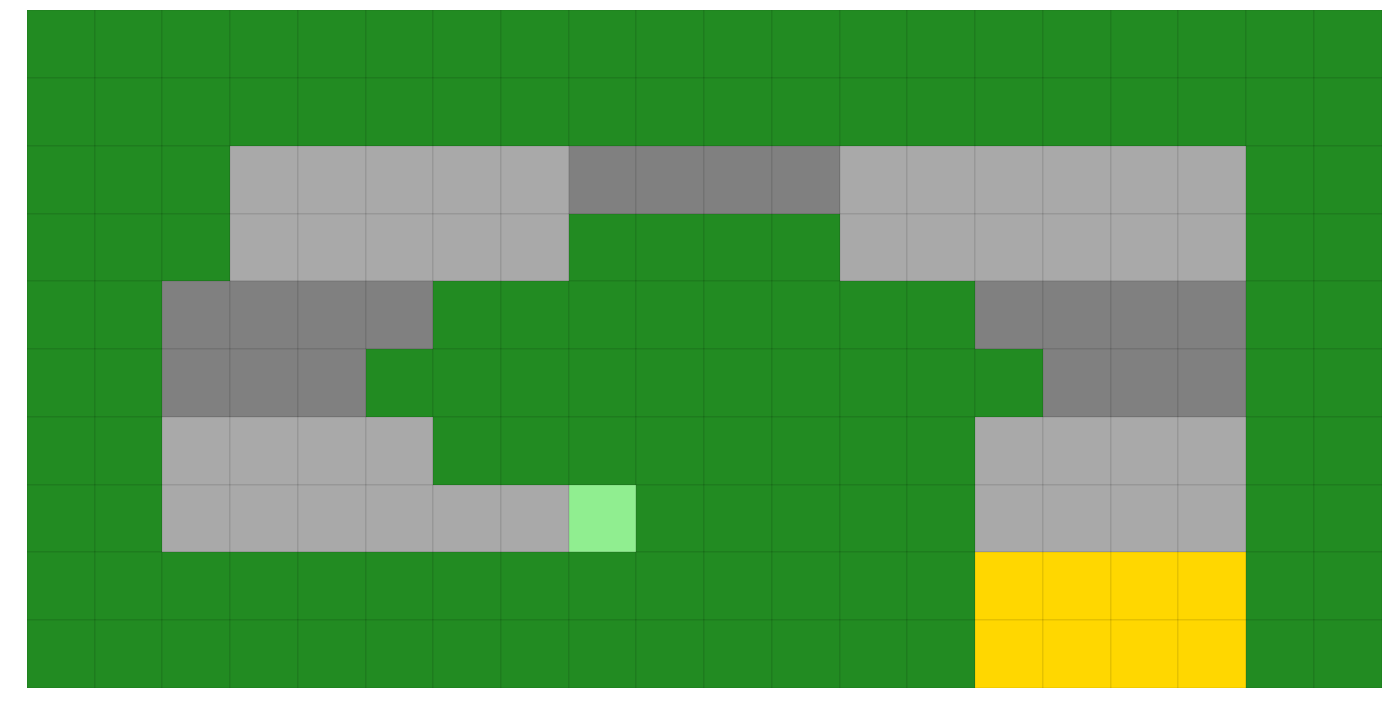

In [6]:
plotting.plot_env(env=rt)

There are also additional maps available - see the racetrack code base for more

In [7]:
print(f'Available tracks: {list(environments.racetrack.TRACKS.keys())}')

Available tracks: ['3x4_basic', '5x4_basic', '10x10', '10x10_basic', '10x10_all_oil', '15x15_basic', '20x20_basic', '20x20_all_oil', '30x30_basic', '20x10_U_all_oil', '20x10_U', '10x10_oil', '20x15_risky']


Tracks are simply lists of strings using a specific set of characters.  See the racetrack code for more detail on how to make your own

In [8]:
for line in environments.racetrack.TRACKS['20x10_U']:
    print(line)

GGGGGGGGGGGGGGGGGGGG
GGGGGGGGGGGGGGGGGGGG
GGG     OOOO      GG
GGG     GGGG      GG
GGOOOOGGGGGGGGOOOOGG
GGOOOGGGGGGGGGGOOOGG
GG    GGGGGGGG    GG
GG      SGGGGG    GG
GGGGGGGGGGGGGGFFFFGG
GGGGGGGGGGGGGGFFFFGG


We can draw them using character art!  For example, here is a custom track with more oil and a different shape than above...

In [9]:
custom_track = \
"""GGGGGGGGGGGGGGGGGGGG
GGGGGGGGGGGGGGGGGGGG
GGGOOOOOOOOOOOOOOOGG
GGG     GGGG      GG
GG    GGGGGGGG    GG
GGOOOOOOSGGGGGOOOOGG
GGGGGGGGGGGGGGFFFFGG
GGGGGGGGGGGGGGFFFFGG"""
custom_track = custom_track.split('\n')

In [10]:
rt_custom = environments.get_racetrack(track=custom_track,
                                 x_vel_limits=(-2, 2),
                                 y_vel_limits=(-2, 2),
                                 x_accel_limits=(-2, 2),
                                 y_accel_limits=(-2, 2),
                                 max_total_accel=2,
                                 )

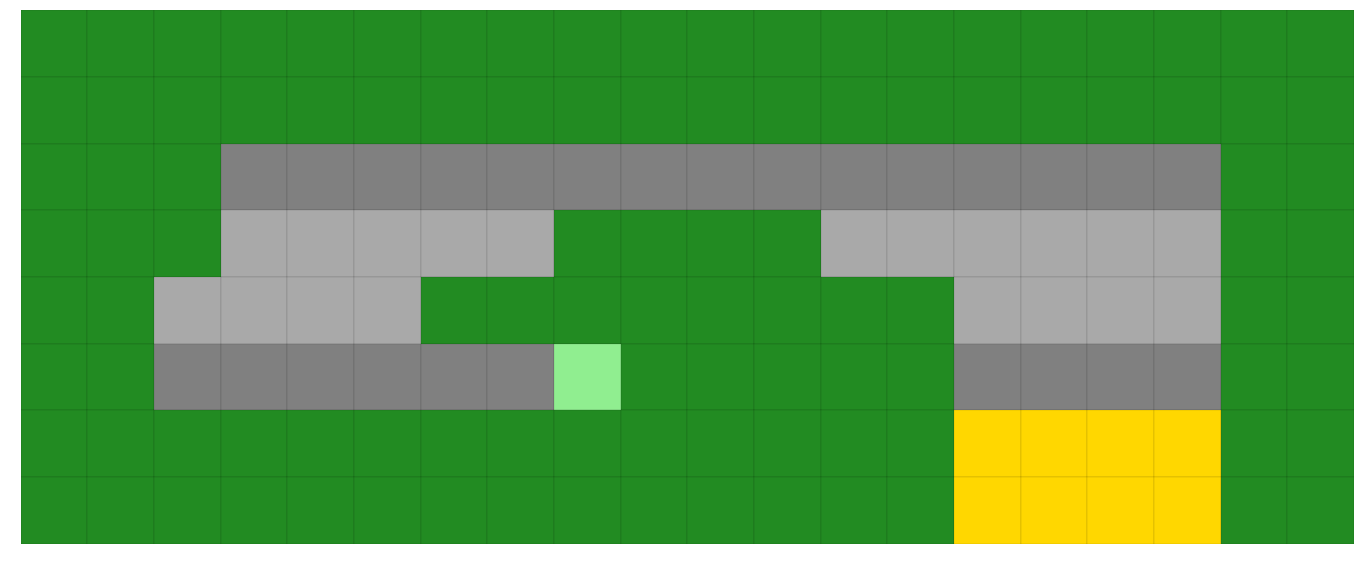

In [11]:
plotting.plot_env(env=rt_custom)

## Solve with Value Iteration and Interrogate Solution

In [12]:
rt_vi = solvers.ValueIteration(env=rt)
rt_vi.iterate_to_convergence()

15:50:35 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver iterating to convergence (Max delta in value function < 0.001 or iters>500)
15:50:38 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver converged to solution in 18 iterations


And we can then score our solution by running it multiple times through the environment

In [13]:
scoring_data = rt_vi.score_policy(iters=500)

score_policy returns a WalkStatistics object that contains details from each episode taken during the scoring.  Easiest way to interact with it is grabbing data as a dataframe

In [14]:
print(f'type(scoring_data) = {type(scoring_data)}')
scoring_data_df = scoring_data.to_dataframe(include_walks=True)
scoring_data_df.head(3)

type(scoring_data) = <class 'lrl.data_stores.data_stores.WalkStatistics'>


,walk_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction,walks
0,0,91.0,11,True,91.0,91.0,0.0,91.0,91.0,11.0,11.0,0.0,11,11,1.0,"[(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (..."
1,1,91.0,11,True,91.0,91.0,0.0,91.0,91.0,11.0,11.0,0.0,11,11,1.0,"[(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (..."
2,2,91.0,11,True,91.0,91.0,0.0,91.0,91.0,11.0,11.0,0.0,11,11,1.0,"[(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (..."


In [15]:
scoring_data_df.tail(3)

,walk_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction,walks
497,497,89.0,13,True,90.473896,91.0,0.880581,89.0,91.0,11.526104,11.0,0.880581,11,13,1.0,"[(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (..."
498,498,91.0,11,True,90.474950,91.0,0.880013,89.0,91.0,11.525050,11.0,0.880013,11,13,1.0,"[(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (..."
499,499,91.0,11,True,90.476000,91.0,0.879445,89.0,91.0,11.524000,11.0,0.879445,11,13,1.0,"[(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (..."


Reward, Steps, and Terminal columns give data on that specific walk, whereas reward_mean, \_median, etc. columns give aggregate scores up until that walk.  For example:

In [16]:
print(f'The reward obtained in the 499th walk was {scoring_data_df.loc[499, "reward"]}')
print(f'The mean reward obtained in the 0-499th walks (inclusive) was {scoring_data_df.loc[499, "reward_mean"]}')

The reward obtained in the 499th walk was 91.0
The mean reward obtained in the 0-499th walks (inclusive) was 90.476


And we can access the actual episode path for each episode

In [17]:
print(f'Episode 0 (directly)          : {scoring_data.walks[0]}')
print(f'Episode 0 (from the dataframe): {scoring_data_df.loc[0, "walks"]}')

Episode 0 (directly)          : [(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (5, 5, 0, 2), (7, 7, 2, 2), (9, 7, 2, 0), (11, 7, 2, 0), (13, 6, 2, -1), (15, 4, 2, -2), (15, 2, 0, -2), (14, 0, -1, -2)]
Episode 0 (from the dataframe): [(8, 2, 0, 0), (6, 2, -2, 0), (5, 3, -1, 1), (5, 5, 0, 2), (7, 7, 2, 2), (9, 7, 2, 0), (11, 7, 2, 0), (13, 6, 2, -1), (15, 4, 2, -2), (15, 2, 0, -2), (14, 0, -1, -2)]


## Plotting Results

And plot 100 randomly chosen episodes on the map, returned as a matplotlib axes

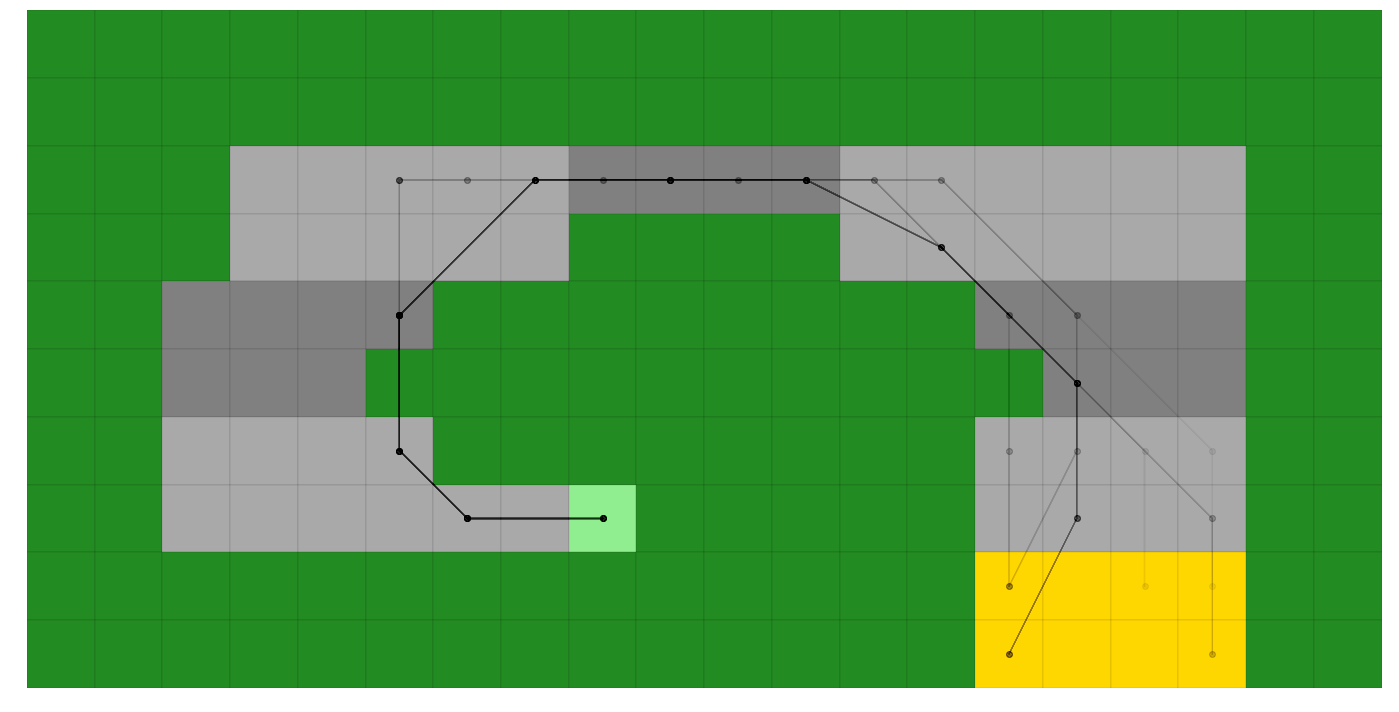

In [18]:
ax_episodes = plotting.plot_episodes(episodes=scoring_data.walks, env=rt, max_episodes=100, )

score_policy also lets us use hypothetical scenario, such as what if we started in a different starting location.  Let's try that by starting in the top left ((x,y) location (3, 7) (x=0 at left, y=0 at bot)) with a velocity of (1, -1), and plot it to our existing axes in red.

15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often ne

15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often needs to be specified so is advisable to include it
15:50:44 - lrl.utils.plotting - plot_episode - WARNING - env arg not strictly required, but often ne

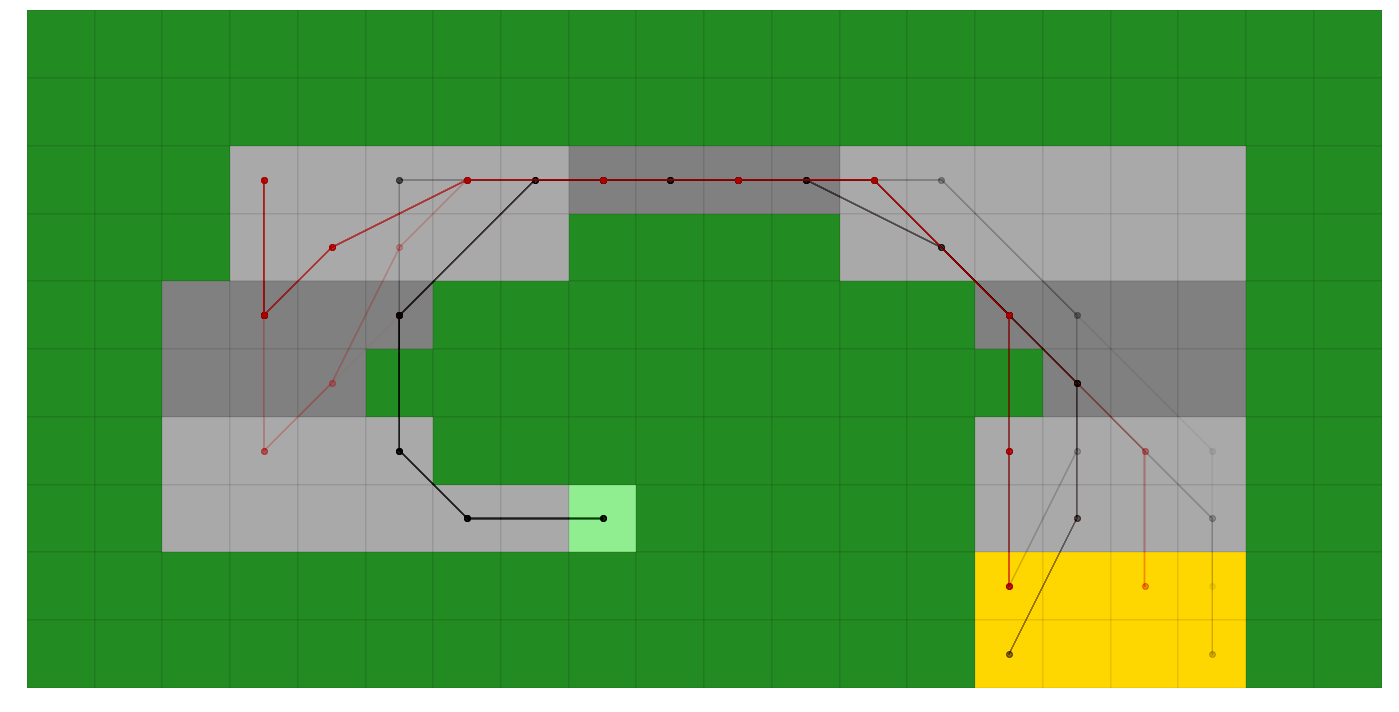

In [19]:
scoring_data_alternate = rt_vi.score_policy(iters=500, initial_state=(3, 7, -2, -2))
ax_episodes_with_alternate = plotting.plot_episodes(episodes=scoring_data_alternate.walks, add_env_to_plot=False, 
                                                    color='r', ax=ax_episodes
#                                                     savefig='my_figure_file',  # If you wanted the figure to save directly 
                                                                                 # to file, use savefig (used throughout 
                                                                                 # lrl's plotting scripts)
                                                    )

# Must get_figure because we're reusing the figure from above and jupyter wont automatically reshow it
ax_episodes_with_alternate.get_figure()

Where we can see the optimal policy takes a first action of (+2, 0) resulting in a first velocity of (0, -2) to avoid hitting the grass on step 1, then it redirects back up and around the track (although it sometimes slips on (3, 5) and drives down to (3, 3) before recovering)

We can also look at the Value function and best policy for all states

**NOTE**: Because state is (x, y, v_x, v_y), it is hard to capture all results on our (x, y) maps.  plot_solver_results in this case plots a map for each (v_x, v_y) combination, with the axis title denoting which is the case.  

In [20]:
# Sorry, this will plot 24 plots normally.  
# To keep concise, we turn matplotlib inline plotting off then back on and selectively plot a few examples
%matplotlib agg
ax_results = plotting.plot_solver_results(env=rt, solver=rt_vi)
%matplotlib inline


C:\Users\Scribs\Anaconda3\envs\lrl\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plots are indexed by the additional state variables (v_x, v_y), so we can see the policy for v_x=0, v_y=0 like:

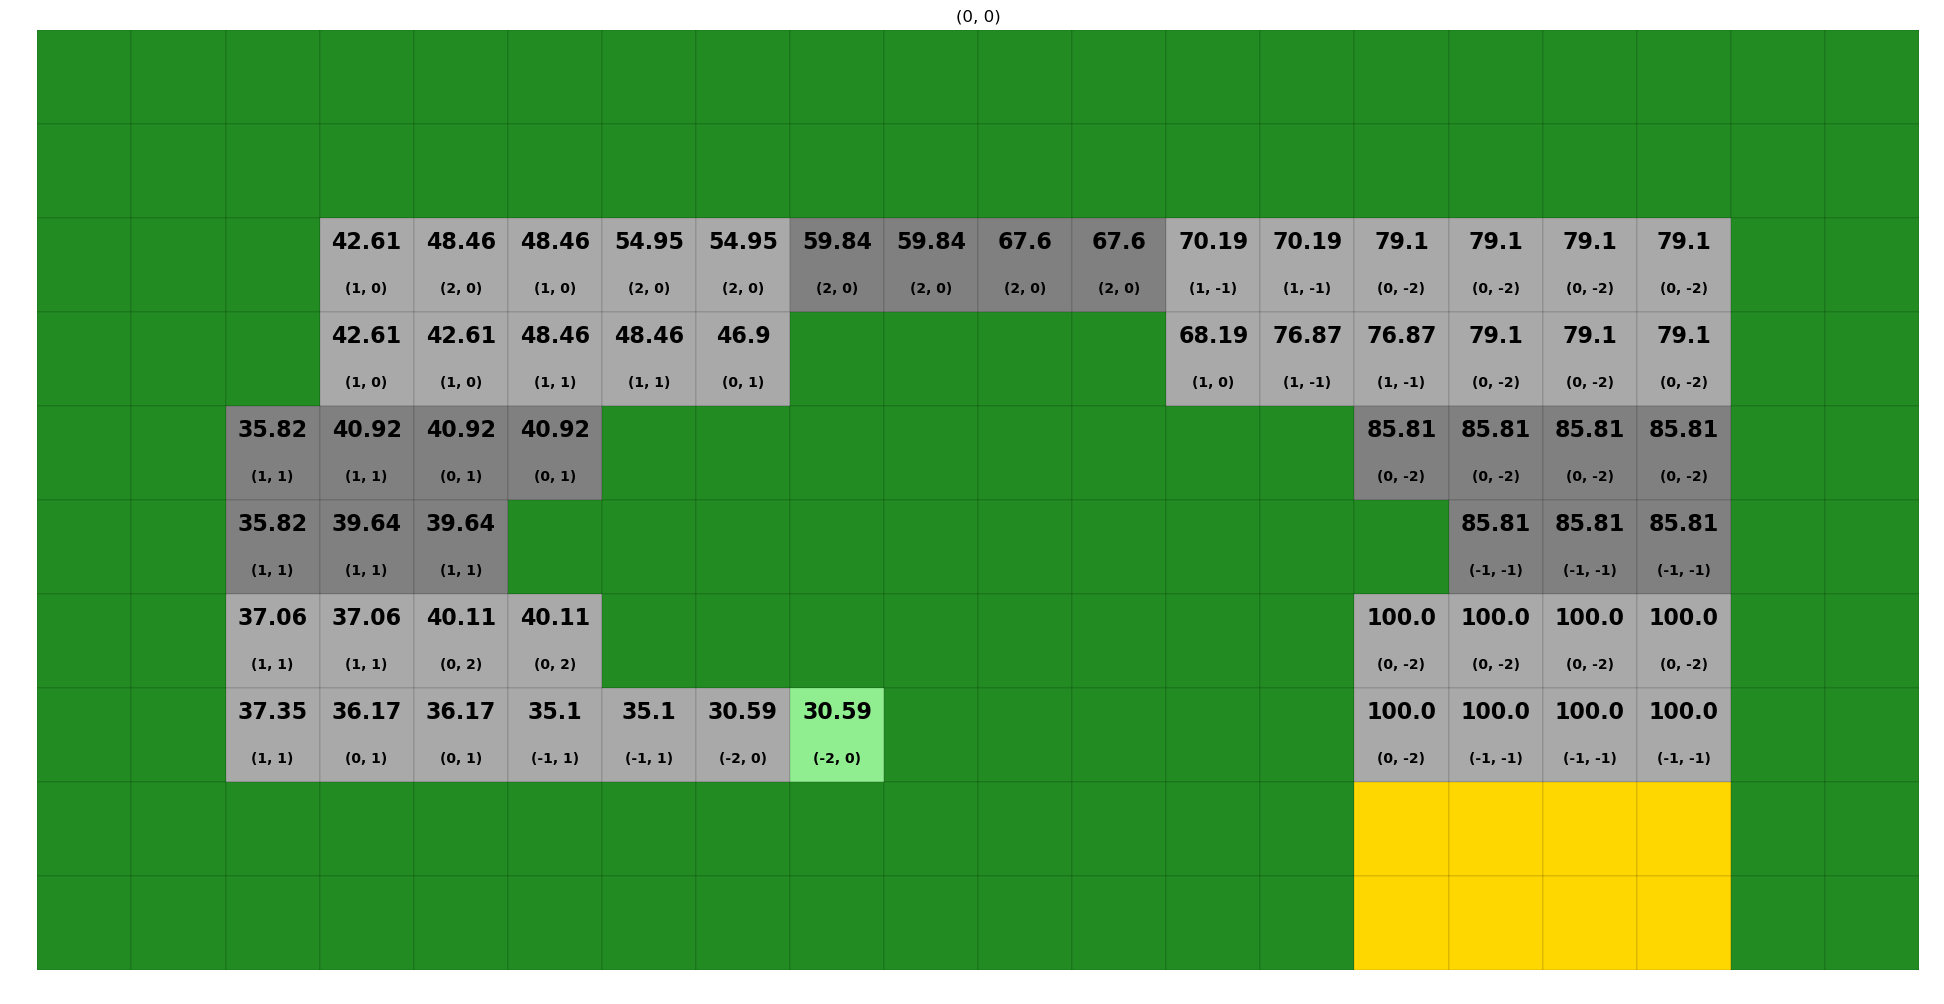

In [21]:
ax_results[(0, 0)].get_figure()

Where we can see the estimated value of the starting (light green) location is 30.59 (including discounting and costs for steps).

We can also look at the policy for (-2, -2) (the velocity for our alternate start used above in red):

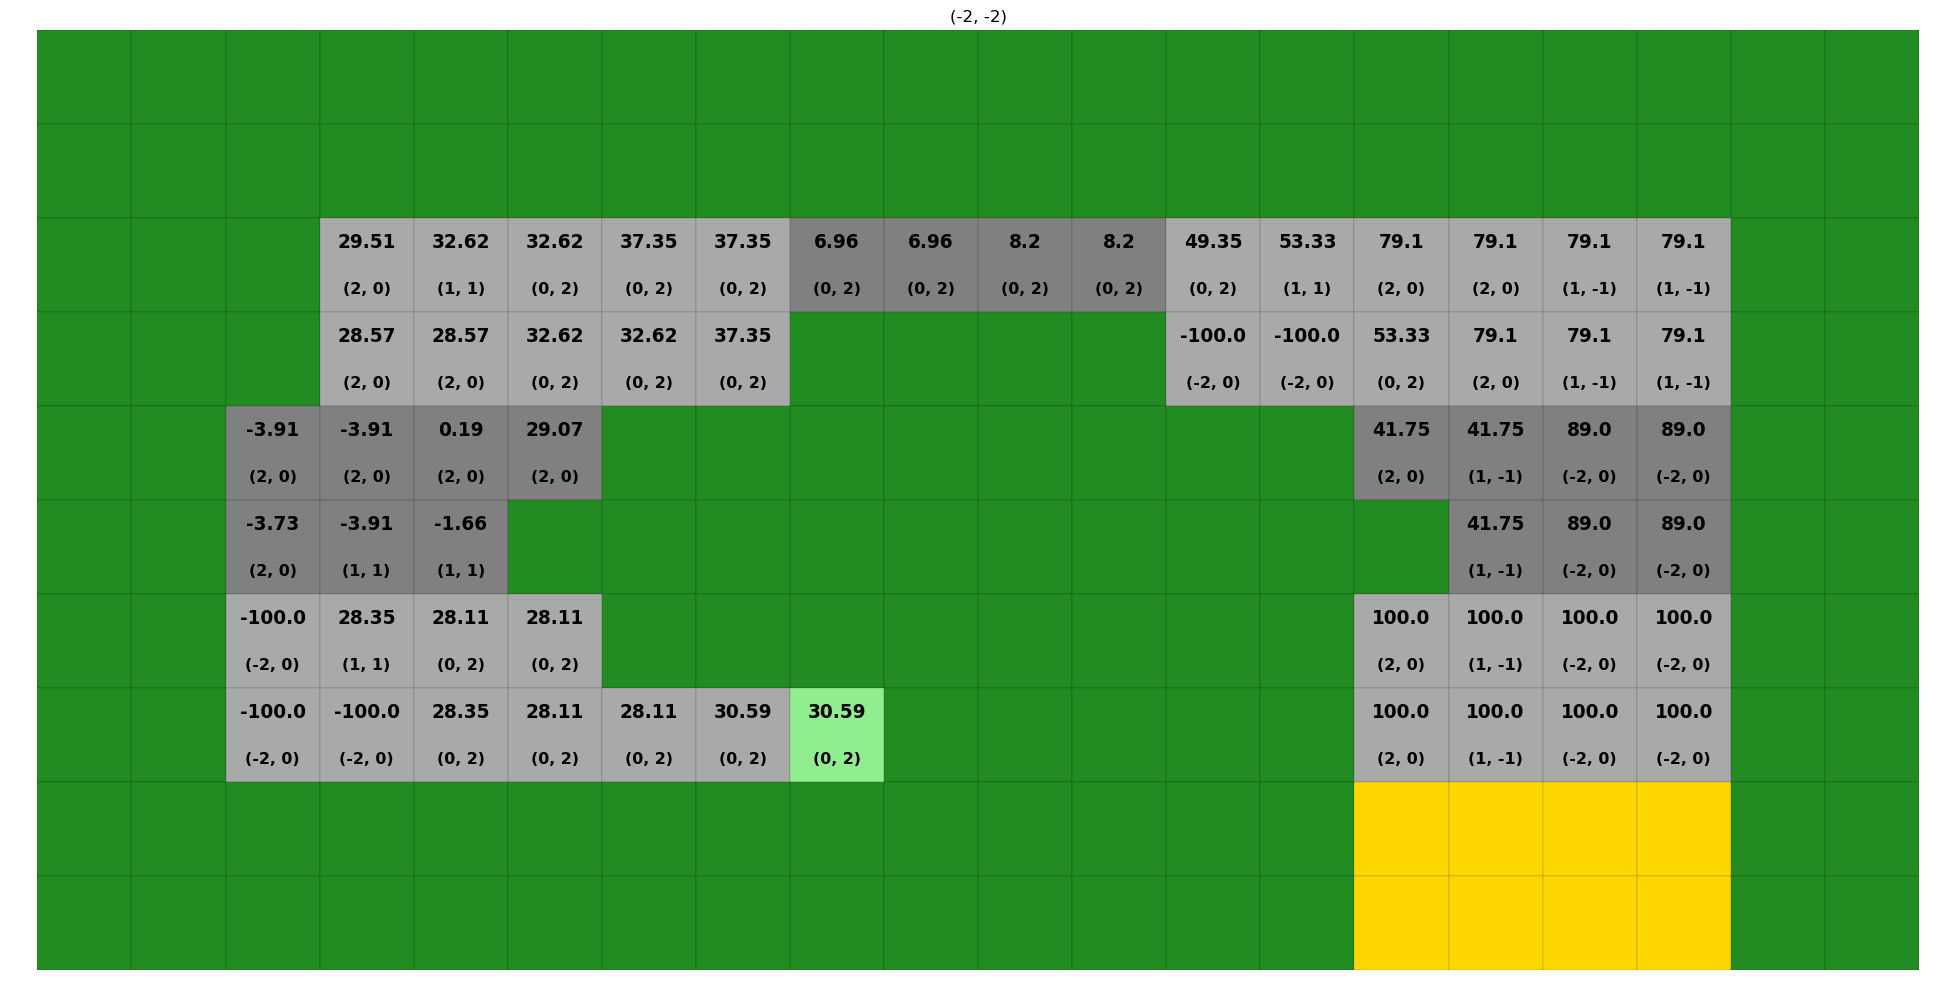

In [22]:
ax_results[(-2, -2)].get_figure()

Where we in the top left tile (3, 7) the optimal policy is (2, 0), just as we saw in our red path plot above.  

We can also see that tile (2, 2) (bottom left) has a -100 value because it is impossible to not crash with a (-2, -2) initialial velocity from tile (2, 2) given that our acceleration limit is 2. 

## Solving with Policy Iteration and Comparing to Value Iteration

We can also use other solvers

In [23]:
rt_pi = solvers.PolicyIteration(env=rt)
rt_pi.iterate_to_convergence()

15:50:56 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver iterating to convergence (1 iteration without change in policy or iters>500)
15:51:00 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver converged to solution in 6 iterations


We can look at how PI and VI converged relative to each other, comparing the maximum change in value function for each iteration

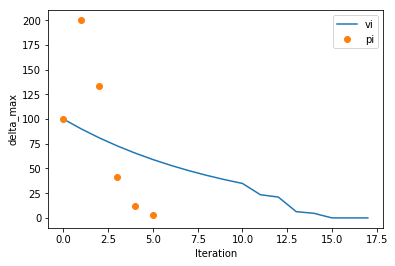

In [24]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(rt_vi, label='vi')

# Or going a little deeper into the API, with style being passed to matplotlib's plot function...
ax = plotting.plot_solver_convergence_from_df(rt_pi.iteration_data.to_dataframe(), y='delta_max', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

And looking at policy changes per iteration

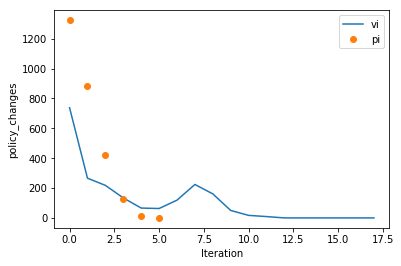

In [25]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(rt_vi, y='policy_changes', label='vi')

# Or going a little deeper into the API...
ax = plotting.plot_solver_convergence_from_df(rt_pi.iteration_data.to_dataframe(), y='policy_changes', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

So we can see PI accomplishes more per iteration.  But, is it faster?  Let's look at time per iteration

Total solution time for Value Iteration (excludes any scoring time):  2.49s
Total solution time for Policy Iteration (excludes any scoring time): 3.39s


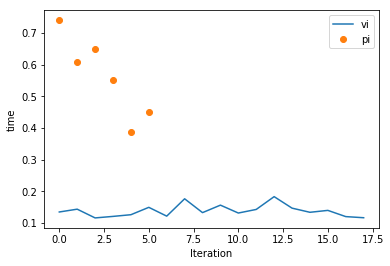

In [26]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(rt_vi, y='time', label='vi')

# Or going a little deeper into the API...
ax = plotting.plot_solver_convergence_from_df(rt_pi.iteration_data.to_dataframe(), y='time', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

print(f'Total solution time for Value Iteration (excludes any scoring time):  {rt_vi.iteration_data.to_dataframe().loc[:, "time"].sum():.2f}s')
print(f'Total solution time for Policy Iteration (excludes any scoring time): {rt_pi.iteration_data.to_dataframe().loc[:, "time"].sum():.2f}s')

## Solve with Q-Learning

We can also use QLearning, although it needs a few parameters

In [27]:
# Let's be explicit with our QLearning settings for alpha and epsilon
alpha = 0.1  # Constant alpha during learning

# Decay function for epsilon (see QLearning() and decay_functions() in documentation for syntax)
# Decay epsilon linearly from 0.2 at timestep (iteration) 0 to 0.05 at timestep 1500, 
# keeping constant at 0.05 for ts>1500
epsilon = {
    'type': 'linear',
    'initial_value': 0.2, 
    'initial_timestep': 0,
    'final_value': 0.05, 
    'final_timestep': 1500
}

# Above PI/VI used the default gamma, but we will specify one here
gamma = 0.9

# Convergence is kinda tough to interpret automatically for Q-Learning.  One good way to monitor convergence is to
# evaluate how good the greedy policy at a given point in the solution is and decide if it is still improving.
# We can enable this with score_while_training (available for Value and Policy Iteration as well)
# NOTE: During scoring runs, the solver is acting greedily and NOT learning from the environment.  These are separate
#       runs solely used to estimate solution progress
# NOTE: Scoring every 50 iterations is probably a bit much, but used to show a nice plot below.  The default 500/500 
#       is probably a better general guidance
score_while_training = {
    'n_trains_per_eval': 50,  # Number of training episodes we run per attempt to score the greedy policy 
                               # (eg: Here we do a scoring run after every 500 training episodes, where training episodes
                               # are the usual epsilon-greedy exploration episodes)
    'n_evals': 250,  # Number of times we run through the env with the greedy policy whenever we score
}
# score_while_training = True  # This calls the default settings, which are also 500/500 like above

rt_ql = solvers.QLearning(env=rt, alpha=alpha, epsilon=epsilon, gamma=gamma,
                          max_iters=5000, score_while_training=score_while_training)

(note how long Q-Learning takes for this environment versus the planning algorithms)

In [28]:
rt_ql.iterate_to_convergence()

15:51:02 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver iterating to convergence (20 episodes with max delta in Q function < 0.1 or iters>5000)
15:51:02 - lrl.solvers.learners - iterate - INFO - Performing iteration (episode) 0 of Q-Learning
15:51:02 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 50
15:51:03 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -102.0, r_max = -102.0
15:51:03 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 100
15:51:04 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -103.0, r_max = -103.0
15:51:04 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 150
15:51:04 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current gre

15:51:34 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -106.72, r_max = -106.0
15:51:34 - lrl.solvers.learners - iterate - INFO - Performing iteration (episode) 1500 of Q-Learning
15:51:34 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 1550
15:51:36 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -100.0, r_max = -100.0
15:51:37 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 1600
15:51:38 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -106.0, r_max = -106.0
15:51:38 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 1650
15:51:39 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_

15:52:23 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -108.176, r_max = -108.0
15:52:23 - lrl.solvers.learners - iterate - INFO - Performing iteration (episode) 3000 of Q-Learning
15:52:23 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 3050
15:52:25 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -100.0, r_max = -100.0
15:52:26 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 3100
15:52:27 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -111.14, r_max = 72.0
15:52:29 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 3150
15:52:31 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_

15:53:31 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = 89.764, r_max = 90.0
15:53:31 - lrl.solvers.learners - iterate - INFO - Performing iteration (episode) 4500 of Q-Learning
15:53:32 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 4550
15:53:33 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = 89.824, r_max = 90.0
15:53:34 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 4600
15:53:35 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = 89.708, r_max = 90.0
15:53:35 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 4650
15:53:36 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = 

Like above, we can plot the number of policy changes per iteration.  But this plot looks very different from above and shows one view of why Q-Learning takes many more iterations (each iteration accomplishes a lot less learning than a planning algorithm)

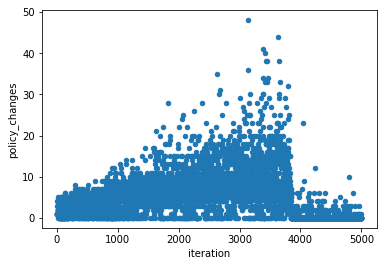

In [29]:
rt_ql_iter_df = rt_ql.iteration_data.to_dataframe()
rt_ql_iter_df.plot(x='iteration', y='policy_changes', kind='scatter', )

We can access the intermediate scoring through the scoring_summary (GeneralIterationData) and scoring_walk_statistics (WalkStatistics) objects

In [30]:
rt_ql_intermediate_scoring_df = rt_ql.scoring_summary.to_dataframe()
rt_ql_intermediate_scoring_df

,iteration,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max
0,50,-102.000,-102.0,0.000000,-102.0,-102.0,4.000,4.0,0.000000,4,4
1,100,-103.000,-103.0,0.000000,-103.0,-103.0,5.000,5.0,0.000000,5,5
2,150,-103.000,-103.0,0.000000,-103.0,-103.0,5.000,5.0,0.000000,5,5
3,200,-102.000,-102.0,0.000000,-102.0,-102.0,4.000,4.0,0.000000,4,4
4,250,-102.000,-102.0,0.000000,-102.0,-102.0,4.000,4.0,0.000000,4,4
5,300,-100.000,-100.0,0.000000,-100.0,-100.0,101.000,101.0,0.000000,101,101
6,350,-103.000,-103.0,0.000000,-103.0,-103.0,5.000,5.0,0.000000,5,5
7,400,-100.000,-100.0,0.000000,-100.0,-100.0,101.000,101.0,0.000000,101,101
8,450,-104.000,-104.0,0.000000,-104.0,-104.0,6.000,6.0,0.000000,6,6
9,500,-103.000,-103.0,0.000000,-103.0,-103.0,5.000,5.0,0.000000,5,5


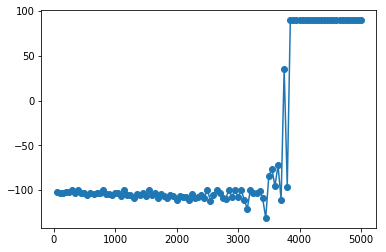

In [31]:
plt.plot(rt_ql_intermediate_scoring_df.loc[:, 'iteration'], rt_ql_intermediate_scoring_df.loc[:, 'reward_mean'], '-o')

In this case we see somewhere between the 3500th and 4000th iteration the solver finds a solution and starts building a policy around it.  This won't always be the case and learning may be more incremental

And if we wanted to access the actual episodes that went into one of these datapoints, they're available in a dictionary of WalkStatistics objects here (keyed by iteration number):

In [32]:
i = 3750
print(f'WalkStatistics for the scoring at iter == {i}:\n')
rt_ql.scoring_walk_statistics[i].to_dataframe().head()

WalkStatistics for the scoring at iter == 3750:



,walk_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction
0,0,79.0,23,True,79.000000,79.0,0.000000,79.0,79.0,23.000000,23.0,0.000000,23,23,1.0
1,1,78.0,24,True,78.500000,78.5,0.500000,78.0,79.0,23.500000,23.5,0.500000,23,24,1.0
2,2,78.0,24,True,78.333333,78.0,0.471405,78.0,79.0,23.666667,24.0,0.471405,23,24,1.0
3,3,78.0,24,True,78.250000,78.0,0.433013,78.0,79.0,23.750000,24.0,0.433013,23,24,1.0
4,4,-110.0,12,True,40.600000,78.0,75.300996,-110.0,79.0,21.400000,24.0,4.715930,12,24,1.0
